In [1]:
import os
import sys
import random
import time
import math
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd


import requests

import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis import predict_pb2
import tensorflow as tf


In [2]:
MRCNN_DIR = os.path.abspath("../external/mask_rcnn")
sys.path.append(MRCNN_DIR)

In [3]:
COCO_DIR = os.path.abspath('../external/mask_rcnn/samples')
sys.path.append(COCO_DIR)


In [4]:
UTILS_DIR = os.path.abspath('../utils')
sys.path.append(UTILS_DIR)


In [5]:
from mrcnn import visualize
from coco.coco import CocoConfig


Using TensorFlow backend.


In [6]:
from utils.transform import ImageTransform
from utils.preprocess import PreprocessImage
from utils.postprocess import PostprocessImage

### Configs

In [7]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [8]:
def get_config():
    class InferenceConfig(CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

    config = InferenceConfig()
    return config


In [9]:
config = get_config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [10]:
transformClass = ImageTransform(config)
preprocessClass = PreprocessImage(config)
postprocessClass = PostprocessImage(config)

### Prepare Image

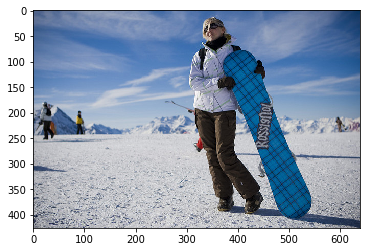

In [11]:
image = skimage.io.imread('test_image.jpg')
# image = transformClass.transform(image, pad_width = 200)
plt.imshow(image)


In [12]:
image.dtype

dtype('uint8')

In [13]:
molded_image, image_meta, anchors, window = preprocessClass.preprocess_input(image)


In [14]:
molded_image.dtype

dtype('float64')

### TF-SERVING REST Call

In [17]:
rest_payload = {
            "signature_name": "serving_default",
            "instances": [
                {
                    'input_anchors': anchors.tolist(),
                    'input_image': molded_image.tolist(),
                    'input_image_meta': image_meta.tolist()
                }]
            }
headers = {"content-type": "application/json"}
rest_json_response = requests.post('http://localhost:8501/v1/models/coco_mrcnn:predict',
                              data = json.dumps(rest_payload),
                              headers = headers)


In [18]:
rest_json_response.status_code


200

In [19]:
rest_result = rest_json_response.json()
rest_mrcnn_detection = np.array(rest_result['predictions'][0]['mrcnn_detection/Reshape_1'])
rest_mrcnn_mask = np.array(rest_result['predictions'][0]['mrcnn_mask/Reshape_1'])
rest_rois, rest_class_ids, rest_scores, rest_masks = \
    postprocessClass.unmold_detections(rest_mrcnn_detection, rest_mrcnn_mask, image.shape, molded_image.shape, window)

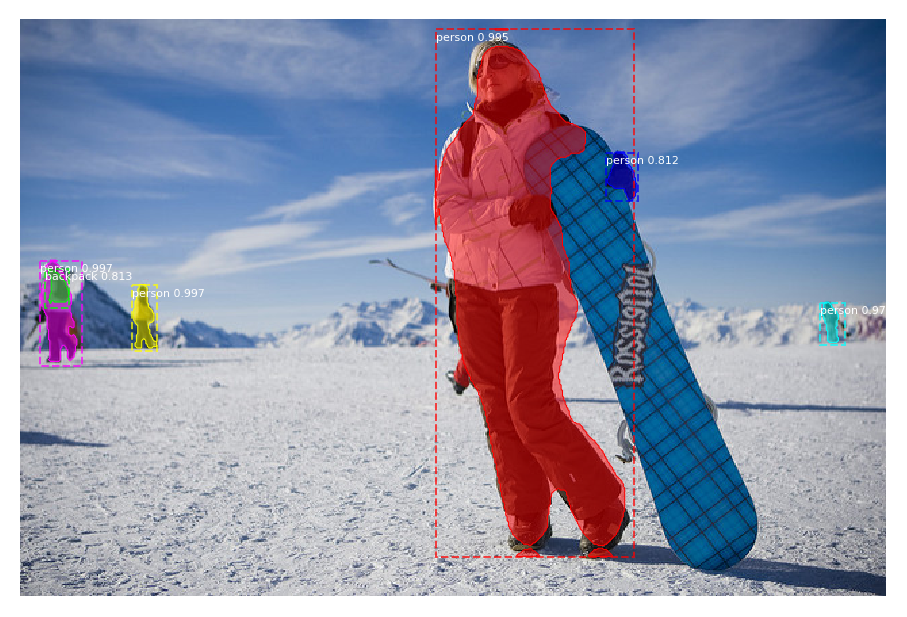

In [20]:
visualize.display_instances(
    image,
    rest_rois,
    rest_masks,
    rest_class_ids,
    class_names,
    rest_scores
)

In [21]:
# time
time_start = time.time()
repeat = 10
for i in range(repeat):
    rest_payload = {
                "signature_name": "serving_default",
                "instances": [
                    {
                        'input_anchors': anchors.tolist(),
                        'input_image': molded_image.tolist(),
                        'input_image_meta': image_meta.tolist()
                    }]
                }
    headers = {"content-type": "application/json"}
    rest_json_response = requests.post('http://localhost:8501/v1/models/coco_mrcnn:predict',
                                  data = json.dumps(rest_payload),
                                  headers = headers)
        
    rest_result = rest_json_response.json()
    rest_mrcnn_detection = np.array(rest_result['predictions'][0]['mrcnn_detection/Reshape_1'])
    rest_mrcnn_mask = np.array(rest_result['predictions'][0]['mrcnn_mask/Reshape_1'])  

    rest_rois, rest_class_ids, rest_scores, rest_masks = \
    postprocessClass.unmold_detections(rest_mrcnn_detection, rest_mrcnn_mask, image.shape, molded_image.shape, window)
    

time_end = time.time()
time_elapsed_sec = time_end - time_start

print('Total elapsed time: {} seconds'.format(time_elapsed_sec))
print('Average latency per batch: {} seconds'.format(time_elapsed_sec / repeat))

Total elapsed time: 78.37271118164062 seconds
Average latency per batch: 7.837271118164063 seconds


### TF-SERVING GRPC Call

In [22]:
channel = grpc.insecure_channel('localhost:8500', options=[('grpc.max_receive_message_length', 4096 * 4096 * 3)])

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

request = predict_pb2.PredictRequest()
request.model_spec.name = 'coco_mrcnn'
request.model_spec.signature_name = 'serving_default'
np.expand_dims(image, axis=0)

request.inputs['input_image'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(molded_image, axis=0), shape = np.expand_dims(molded_image, axis=0).shape, dtype = "float32"))
request.inputs['input_image_meta'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(image_meta, axis=0), shape = np.expand_dims(image_meta, axis=0).shape, dtype = "float32"))
request.inputs['input_anchors'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(anchors, axis=0), shape = np.expand_dims(anchors, axis=0).shape, dtype = "float32"))

grpc_result = stub.Predict(request)

In [23]:
grpc_mrcnn_detection = np.array(grpc_result.outputs["mrcnn_detection/Reshape_1"].float_val)
grpc_mrcnn_mask = np.array(grpc_result.outputs["mrcnn_mask/Reshape_1"].float_val)
grpc_rois, grpc_class_ids, grpc_scores, grpc_masks = \
    postprocessClass.unmold_detections(grpc_mrcnn_detection, grpc_mrcnn_mask, image.shape, molded_image.shape, window)

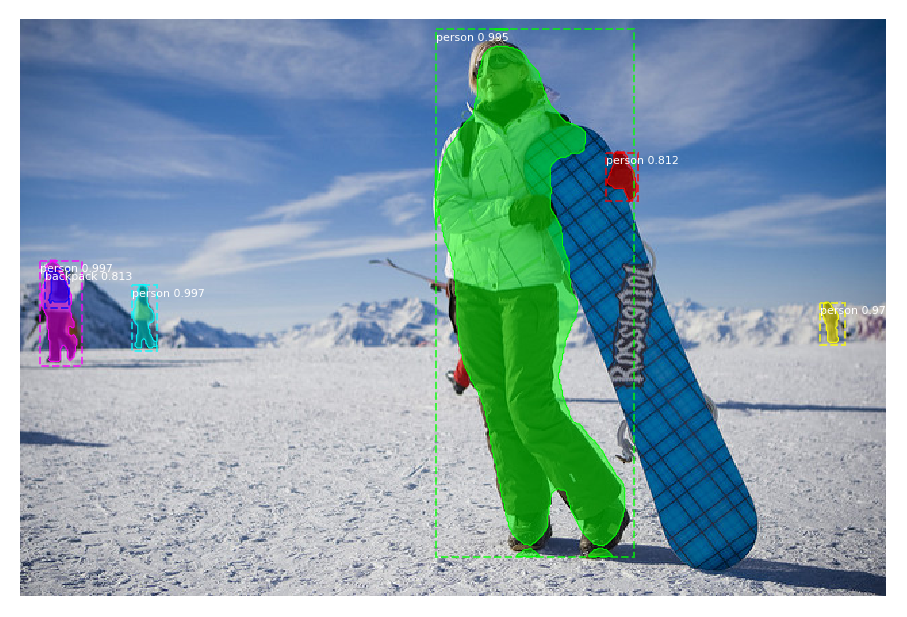

In [24]:
visualize.display_instances(
    image,
    grpc_rois,
    grpc_masks,
    grpc_class_ids,
    class_names,
    grpc_scores
)

In [25]:
# time
time_start = time.time()
repeat = 10
for i in range(repeat):
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'coco_mrcnn'
    request.model_spec.signature_name = 'serving_default'
    np.expand_dims(image, axis=0)

    request.inputs['input_image'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(molded_image, axis=0), shape = np.expand_dims(molded_image, axis=0).shape, dtype = "float32"))
    request.inputs['input_image_meta'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(image_meta, axis=0), shape = np.expand_dims(image_meta, axis=0).shape, dtype = "float32"))
    request.inputs['input_anchors'].CopyFrom(
        tf.make_tensor_proto(np.expand_dims(anchors, axis=0), shape = np.expand_dims(anchors, axis=0).shape, dtype = "float32"))

    grpc_result = stub.Predict(request)
    
    grpc_mrcnn_detection = np.array(grpc_result.outputs["mrcnn_detection/Reshape_1"].float_val)
    grpc_mrcnn_mask = np.array(grpc_result.outputs["mrcnn_mask/Reshape_1"].float_val)

    grpc_rois, grpc_class_ids, grpc_scores, grpc_masks = \
    postprocessClass.unmold_detections(grpc_mrcnn_detection, grpc_mrcnn_mask, image.shape, molded_image.shape, window)
    
time_end = time.time()
time_elapsed_sec = time_end - time_start

print('Total elapsed time: {} seconds'.format(time_elapsed_sec))
print('Average latency per batch: {} seconds'.format(time_elapsed_sec / repeat))

Total elapsed time: 19.056264400482178 seconds
Average latency per batch: 1.9056264400482177 seconds
